In [1]:
import pandas as pd
import os
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from statsmodels.stats.weightstats import DescrStatsW
from sklearn.linear_model import LinearRegression
from jinja2 import Template

In [2]:
CALIB = "../data/processed/usfia_fvs_calibstats.csv"
CASES = "../data/processed/usfia_fvs_cases.csv"
FIA_DB = "../data/raw/SQLite_FIADB_ENTIRE.db"
USE_VARIANT = "NC"
# NC (Klamath Mountains) Variant of FVS recognizes species in this order
SPP_ORDER = [299, 117, 202, 15, 361, 81, 818, 631, 20, 122, 998, 211]

In [3]:
cases = pd.read_csv(CASES)
cases.columns = [col.upper() for col in cases.columns]
cases.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 388726 entries, 0 to 388725
Data columns (total 12 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   CASEID       388726 non-null  object 
 1   STAND_CN     388726 non-null  int64  
 2   STANDID      388726 non-null  object 
 3   MGMTID       388726 non-null  object 
 4   RUNTITLE     0 non-null       float64
 5   KEYWORDFILE  388726 non-null  object 
 6   SAMPLINGWT   388726 non-null  float64
 7   VARIANT      388726 non-null  object 
 8   VERSION      388726 non-null  object 
 9   RV           388726 non-null  int64  
 10  GROUPS       0 non-null       float64
 11  RUNDATETIME  388726 non-null  object 
dtypes: float64(3), int64(2), object(7)
memory usage: 35.6+ MB


In [4]:
use_ids = cases.loc[cases.VARIANT == USE_VARIANT]["CASEID"].values
use_cns = cases.loc[cases.VARIANT == USE_VARIANT]["STAND_CN"].values
# use_ids = pd.unique(cases.CASEID)
# use_cns = pd.unique(cases.STAND_CN)

In [5]:
SQL = f"""
SELECT s.STAND_ID as STANDID, 
    s.STAND_CN, 
    s.VARIANT, 
    s.LOCATION, 
    s.LATITUDE, 
    s.LONGITUDE, 
    c.SITECLCD, 
    c.FORTYPCD
FROM FVS_STANDINIT_COND s
INNER JOIN COND c
ON s.STAND_CN = c.CN
WHERE s.STAND_CN IN {tuple(use_cns)}
"""

covars = pd.read_sql(SQL, f"sqlite:///{os.path.abspath(FIA_DB)}")
covars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2464 entries, 0 to 2463
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   STANDID    2464 non-null   object 
 1   STAND_CN   2464 non-null   object 
 2   VARIANT    2464 non-null   object 
 3   LOCATION   2464 non-null   int64  
 4   LATITUDE   2464 non-null   float64
 5   LONGITUDE  2464 non-null   float64
 6   SITECLCD   2464 non-null   float64
 7   FORTYPCD   2464 non-null   float64
dtypes: float64(4), int64(1), object(3)
memory usage: 154.1+ KB


In [6]:
ref_spp = pd.read_sql("REF_SPECIES", f"sqlite:///{os.path.abspath(FIA_DB)}")
ref_spp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2677 entries, 0 to 2676
Data columns (total 82 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   CN                            2677 non-null   int64         
 1   SPCD                          2677 non-null   float64       
 2   COMMON_NAME                   2677 non-null   object        
 3   SHARED_COMMON_NAME_IND        2677 non-null   object        
 4   GENUS                         2677 non-null   object        
 5   SPECIES                       2677 non-null   object        
 6   VARIETY                       21 non-null     object        
 7   SUBSPECIES                    8 non-null      object        
 8   SPECIES_SYMBOL                2677 non-null   object        
 9   E_SPGRPCD                     2677 non-null   int64         
 10  W_SPGRPCD                     2677 non-null   int64         
 11  C_SPGRPCD                     

In [7]:
fortyp = pd.read_sql("REF_FOREST_TYPE", f"sqlite:///{os.path.abspath(FIA_DB)}")
fortyp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207 entries, 0 to 206
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   VALUE                 207 non-null    int64         
 1   MEANING               207 non-null    object        
 2   TYPGRPCD              207 non-null    int64         
 3   MANUAL_START          207 non-null    float64       
 4   MANUAL_END            16 non-null     float64       
 5   ALLOWED_IN_FIELD      207 non-null    object        
 6   CREATED_BY            207 non-null    object        
 7   CREATED_DATE          207 non-null    datetime64[ns]
 8   CREATED_IN_INSTANCE   207 non-null    object        
 9   MODIFIED_BY           180 non-null    object        
 10  MODIFIED_DATE         180 non-null    datetime64[ns]
 11  MODIFIED_IN_INSTANCE  180 non-null    object        
dtypes: datetime64[ns](2), float64(2), int64(2), object(6)
memory usage: 19.5+ KB


In [8]:
calib = pd.read_csv(CALIB)
calib.columns = [col.upper() for col in calib.columns]
calib = calib.loc[calib.CASEID.isin(use_ids)]
calib = calib.merge(
    ref_spp[["SPCD", "COMMON_NAME"]], left_on="SPECIESFIA", right_on="SPCD", how="left"
)
calib.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2090 entries, 0 to 2089
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   CASEID         2090 non-null   object 
 1   STANDID        2090 non-null   object 
 2   TREESIZE       2090 non-null   object 
 3   SPECIESFVS     2090 non-null   object 
 4   SPECIESPLANTS  2090 non-null   object 
 5   SPECIESFIA     2090 non-null   int64  
 6   NUMTREES       2090 non-null   int64  
 7   SCALEFACTOR    2090 non-null   float64
 8   STDERRRATIO    1860 non-null   float64
 9   WEIGHTTOINPUT  1860 non-null   float64
 10  READCORMULT    2090 non-null   float64
 11  SPCD           2090 non-null   float64
 12  COMMON_NAME    2090 non-null   object 
dtypes: float64(5), int64(2), object(6)
memory usage: 212.4+ KB


In [9]:
df = calib.merge(covars, left_on="STANDID", right_on="STANDID", how="left")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2090 entries, 0 to 2089
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   CASEID         2090 non-null   object 
 1   STANDID        2090 non-null   object 
 2   TREESIZE       2090 non-null   object 
 3   SPECIESFVS     2090 non-null   object 
 4   SPECIESPLANTS  2090 non-null   object 
 5   SPECIESFIA     2090 non-null   int64  
 6   NUMTREES       2090 non-null   int64  
 7   SCALEFACTOR    2090 non-null   float64
 8   STDERRRATIO    1860 non-null   float64
 9   WEIGHTTOINPUT  1860 non-null   float64
 10  READCORMULT    2090 non-null   float64
 11  SPCD           2090 non-null   float64
 12  COMMON_NAME    2090 non-null   object 
 13  STAND_CN       2090 non-null   object 
 14  VARIANT        2090 non-null   object 
 15  LOCATION       2090 non-null   int64  
 16  LATITUDE       2090 non-null   float64
 17  LONGITUDE      2090 non-null   float64
 18  SITECLCD

In [10]:
abund = (
    df.groupby(by=["TREESIZE", "COMMON_NAME"])["SCALEFACTOR"]
    .count()
    .loc["LG"]
    .sort_values(ascending=False)
)
abund

COMMON_NAME
Douglas-fir              650
tanoak                   357
California black oak     258
redwood                  165
unknown dead hardwood    156
Pacific madrone          113
white fir                 51
ponderosa pine            36
unknown dead conifer      28
sugar pine                24
incense-cedar             19
California red fir         3
Name: SCALEFACTOR, dtype: int64

In [11]:
calib.columns

Index(['CASEID', 'STANDID', 'TREESIZE', 'SPECIESFVS', 'SPECIESPLANTS',
       'SPECIESFIA', 'NUMTREES', 'SCALEFACTOR', 'STDERRRATIO', 'WEIGHTTOINPUT',
       'READCORMULT', 'SPCD', 'COMMON_NAME'],
      dtype='object')

In [12]:
df.groupby(by=["TREESIZE", "COMMON_NAME"])[["SCALEFACTOR", "READCORMULT"]].agg(
    ["mean", "median", "count"]
).loc["LG"].loc[abund.index]

SCALEFACTOR                 READCORMULT                
                             mean    median count        mean    median count
COMMON_NAME                                                                  
Douglas-fir              0.803478  0.771250   650    0.795023  0.708749   650
tanoak                   0.648639  0.614126   357    0.631842  0.573851   357
California black oak     1.128464  0.982078   258    1.136404  0.961571   258
redwood                  1.196557  0.985529   165    1.205837  0.974993   165
unknown dead hardwood    1.210048  0.994222   156    1.223689  0.989866   156
Pacific madrone          0.682943  0.617508   113    0.673640  0.567398   113
white fir                0.850636  0.777098    51    0.836352  0.737643    51
ponderosa pine           0.456675  0.352024    36    0.449330  0.351960    36
unknown dead conifer     0.935772  0.459721    28    0.944610  0.458666    28
sugar pine               0.521262  0.321979    24    0.514488  0.321971    24
incense-cedar            0.711213  0.691139    19    0.704690  0.634886    19
California red fir       1.095287  1.055915     3    1.118827  1.075394     3

In [13]:
means = df.groupby(by=["TREESIZE", "COMMON_NAME", "SITECLCD"])["READCORMULT"].mean()
pivot_means = pd.pivot_table(
    means.loc["LG"].reset_index(),
    index="COMMON_NAME",
    columns="SITECLCD",
    values="READCORMULT",
)
pivot_means.loc[abund.index].round(3).fillna("--")

SITECLCD,1.0,2.0,3.0,4.0,5.0,6.0,7.0
COMMON_NAME,,,,,,,
Douglas-fir,1.188,0.89,0.873,0.763,0.733,0.561,0.55
tanoak,0.7,0.653,0.723,0.601,0.550,0.464,0.49
California black oak,1.362,2.388,1.438,1.119,1.016,1.047,1.089
redwood,1.499,1.331,1.1,0.981,0.695,--,0.224
unknown dead hardwood,1.695,1.918,1.352,1.297,0.933,0.772,0.6
Pacific madrone,1.296,0.659,0.775,0.678,0.705,0.402,0.415
white fir,0.646,0.951,1.009,0.737,0.977,0.312,0.457
ponderosa pine,--,0.484,0.68,0.504,0.454,0.424,0.137
unknown dead conifer,2.398,2.027,1.093,0.556,0.743,0.214,0.469


In [14]:
counts = df.groupby(by=["TREESIZE", "COMMON_NAME", "SITECLCD"])["READCORMULT"].count()
pivot_counts = pd.pivot_table(
    counts.loc["LG"].reset_index(),
    index="COMMON_NAME",
    columns="SITECLCD",
    values="READCORMULT",
)
pivot_counts.loc[abund.index].astype("Int64")

SITECLCD,1.0,2.0,3.0,4.0,5.0,6.0,7.0
COMMON_NAME,,,,,,,
Douglas-fir,14,59,210,190,118,43,16
tanoak,14,31,116,109,65,17,5
California black oak,1,3,30,49,44,16,115
redwood,32,48,52,26,6,<NA>,1
unknown dead hardwood,9,16,51,32,14,6,28
Pacific madrone,2,7,27,38,21,5,13
white fir,1,3,7,22,15,1,2
ponderosa pine,<NA>,1,6,6,9,9,5
unknown dead conifer,6,1,2,2,2,7,8


In [15]:
def weighted_percentile_of_score(x, weights, score, kind="weak"):
    # copied from https://stackoverflow.com/q/48266788/7638539
    npx = np.array(x)
    npw = np.array(weights)

    if kind == "rank":  # Equivalent to 'weak' since we have weights.
        kind = "weak"

    if kind in ["strict", "mean"]:
        indx = npx < score
        strict = sum(npw[indx]) / sum(weights)
    if kind == "strict":
        return strict

    if kind in ["weak", "mean"]:
        indx = npx <= score
        weak = sum(npw[indx]) / sum(weights)
    if kind == "weak":
        return weak

    if kind == "mean":
        return (strict + weak) / 2

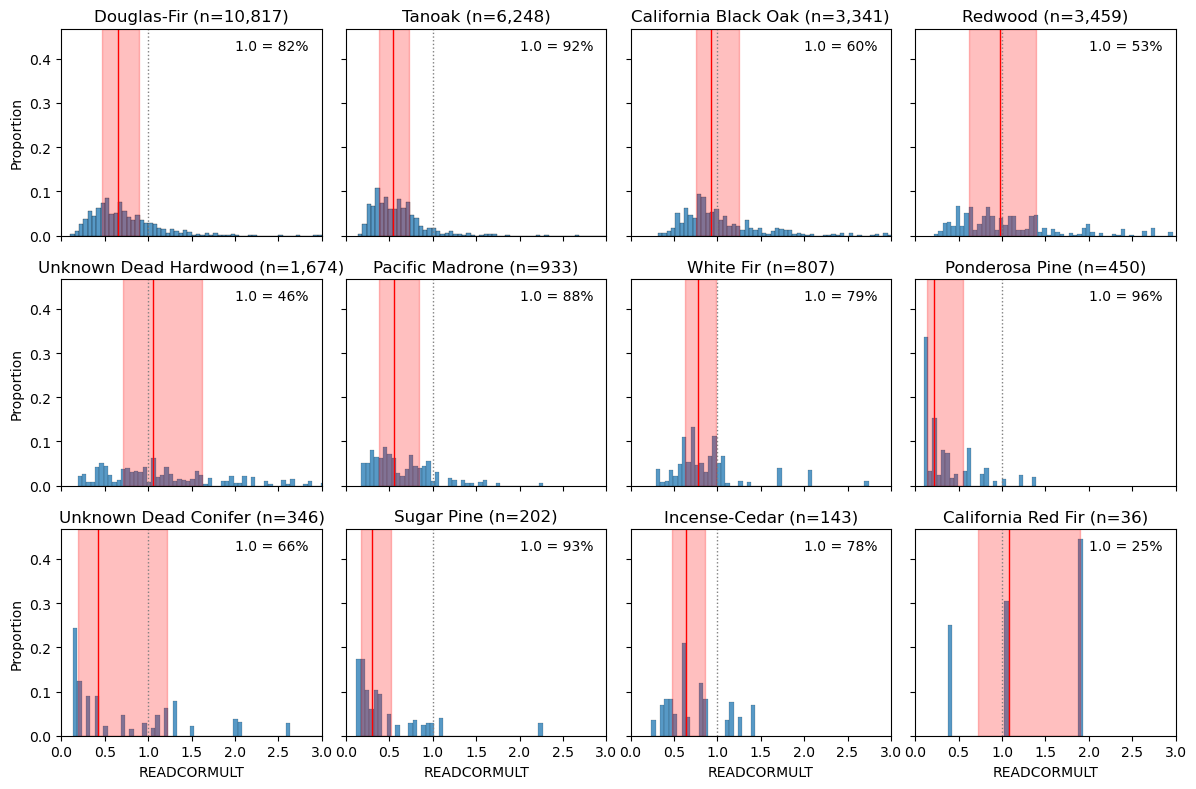

In [16]:
fig, axs = plt.subplots(3, 4, sharex=True, sharey=True, figsize=(12, 8))
spp = abund.index
for i, sp in enumerate(spp):
    data = calib.loc[(calib.TREESIZE == "LG") & (calib.COMMON_NAME == sp)]
    sns.histplot(
        data=data,
        x="READCORMULT",
        weights="NUMTREES",
        ax=axs.ravel()[i],
        binwidth=0.05,
        stat="proportion",
    )
    axs.ravel()[i].set_title(f"{sp.title()} (n={data['NUMTREES'].sum():,.0f})")
    axs.ravel()[i].axvline(1.0, lw=1.0, ls=":", color="gray")
    wq = DescrStatsW(data=data.READCORMULT, weights=data.NUMTREES)
    lo, mid, hi = wq.quantile(probs=[0.25, 0.5, 0.75], return_pandas=False)
    axs.ravel()[i].axvline(mid, lw=1.0, color="red")
    axs.ravel()[i].axvspan(lo, hi, color="red", alpha=0.25)
    pct = weighted_percentile_of_score(data.READCORMULT, data.NUMTREES, 1.0)
    axs.ravel()[i].text(
        0.95, 0.90, f"1.0 = {pct:.0%}", transform=axs.ravel()[i].transAxes, ha="right"
    )
axs.ravel()[i].set_xlim(0, 3)
plt.tight_layout()
plt.show()

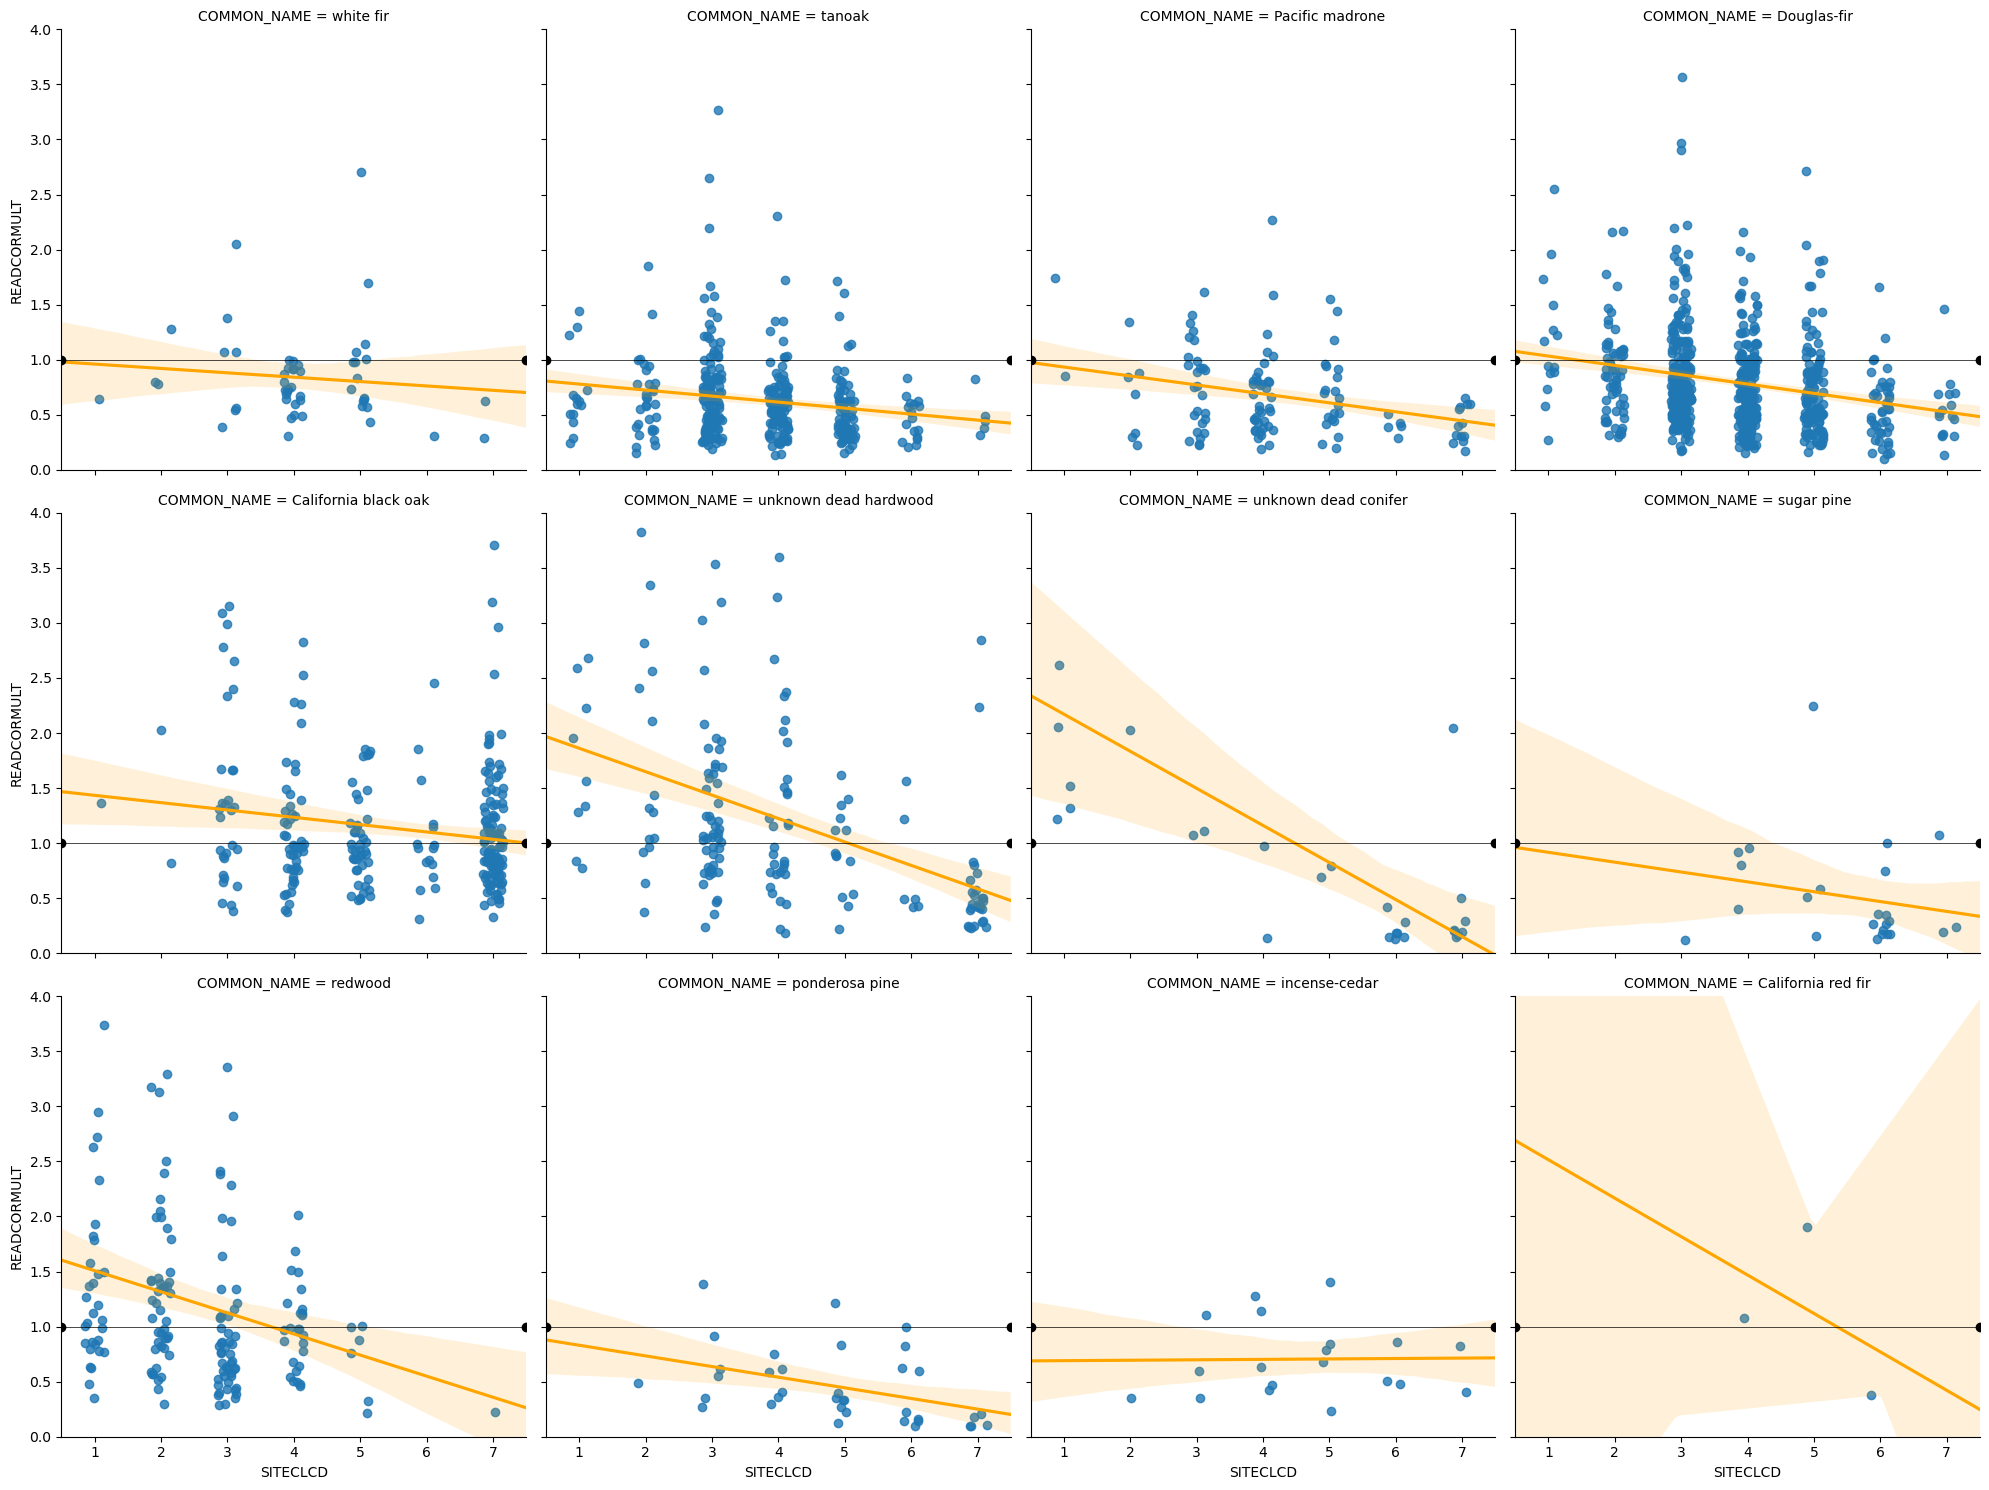

In [17]:
g = sns.lmplot(
    data=df.loc[(calib.TREESIZE == "LG") & (calib.SPECIESFIA.isin(SPP_ORDER))],
    x="SITECLCD",
    y="READCORMULT",
    col="COMMON_NAME",
    col_wrap=4,
    facet_kws=dict(sharex=True, sharey=True, xlim=(0.5, 7.5), ylim=(0, 4)),
    line_kws=dict(color="orange"),
    x_jitter=0.15,
    truncate=False,
)
g.map(plt.axhline, y=1.0, color="black", lw=0.5, ls="solid", marker="none")

In [18]:
site_classes = np.arange(1, 8)

multipliers = pd.DataFrame(
    index=pd.Series(SPP_ORDER, name="SPECIESFIA"),
    columns=pd.Series(site_classes, name="SITECLCD"),
)
for spp in multipliers.index:
    data = df.loc[(calib.TREESIZE == "LG") & (calib.SPECIESFIA == spp)]
    print(spp, len(data))
    if len(data) >= 10:
        lr = LinearRegression()
        lr.fit(
            data.SITECLCD.values.reshape(-1, 1), data.READCORMULT.values.reshape(-1, 1)
        )
        multipliers.loc[spp] = lr.predict(site_classes.reshape(-1, 1)).ravel().round(3)
    else:
        multipliers.loc[spp] = 1

new_idx = pd.Series(
    [f"sp{x+1:0>2}" for x in np.arange(len(multipliers))],
    name="SPP_IDX",
)
multipliers = multipliers.reset_index().set_index(new_idx)
multipliers

299 28
117 24
202 650
15 51
361 113
81 19
818 258
631 357
20 3
122 36
998 156
211 165


SITECLCD,SPECIESFIA,1,2,3,4,5,6,7
SPP_IDX,,,,,,,,
sp01,299,2.171,1.835,1.498,1.161,0.824,0.488,0.151
sp02,117,0.917,0.828,0.738,0.649,0.559,0.47,0.38
sp03,202,1.034,0.949,0.864,0.78,0.695,0.61,0.526
sp04,15,0.961,0.921,0.882,0.842,0.802,0.762,0.723
sp05,361,0.934,0.853,0.772,0.69,0.609,0.527,0.446
sp06,81,0.691,0.694,0.698,0.702,0.706,0.71,0.714
sp07,818,1.434,1.368,1.301,1.235,1.168,1.102,1.035
sp08,631,0.779,0.725,0.67,0.616,0.561,0.507,0.452
sp09,20,1,1,1,1,1,1,1


In [19]:
READCORD_TEMPLATE = "../models/READCORD_template.kcp"
site_classes = np.arange(1, 8)
for siteclcd in site_classes:
    to_write = multipliers[siteclcd].apply(lambda x: f"{x:>10}").to_dict()
    to_write["siteclcd"] = siteclcd
    with open(READCORD_TEMPLATE, "r") as f:
        template = Template(f.read())

    outpath = f"../models/READCORD_var{USE_VARIANT}_siteclcd{siteclcd}.kcp"
    with open(outpath, "w") as k:
        k.write(template.render(**to_write))